In [94]:
# 1. Import packages
import os,keras,cv2
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import datetime
from keras import layers,losses,callbacks,activations,regularizers,metrics,applications,optimizers

In [95]:
# 2. Data loading


data = os.path.join('datasets', 'stenosed artery classification')
BATCH_SIZE = 32
IMG_SIZE = (350, 350)

train_dataset, validation_dataset = keras.utils.image_dataset_from_directory(data,
                                                          shuffle=True,
                                                          batch_size=BATCH_SIZE,
                                                          image_size=IMG_SIZE,
                                                          validation_split=0.3,
                                                          subset='both',
                                                          seed=69)

Found 1152 files belonging to 2 classes.
Using 807 files for training.
Using 345 files for validation.


['negative', 'positive']


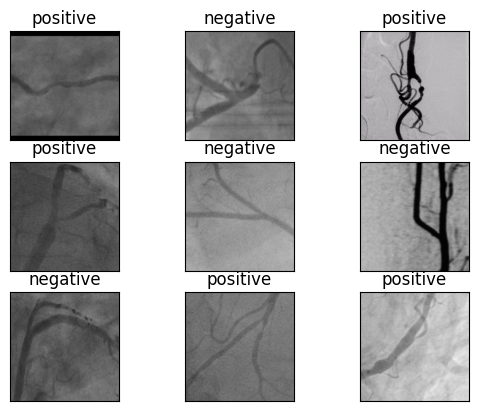

In [96]:
# 3. Inspect some data samples from the dataset
class_names = train_dataset.class_names
print(class_names)
batch_1 = train_dataset.take(1)
for feature,label in batch_1:
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(feature[i].numpy().astype('uint8'))
        plt.title(class_names[label[i]])
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
plt.show()

In [97]:
# 4. Split the validation dataset into 2 equal splits: for val and test
nBatches = validation_dataset.cardinality().numpy()
print(nBatches)
val_dataset = validation_dataset.take(nBatches//2)
test_dataset = validation_dataset.skip(nBatches//2)

11


In [98]:
# 5. Convert the val and test dataset back to PrefetchDataset
val_dataset = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [99]:
# 6. Create a sequential model for augmentation
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(factor=0.2),
    layers.RandomZoom(height_factor=(-0.2, 0.2)),  # Add random zoom
    layers.RandomContrast(factor=0.2),  # Add random contrast
    layers.RandomBrightness(factor=0.2),  # Add random brightness
])

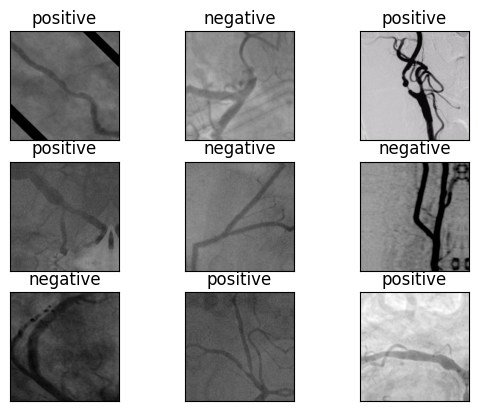

In [100]:
feature_augmented = data_augmentation(feature)
for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(feature_augmented[i].numpy().astype('uint8'))
        plt.title(class_names[label[i]])
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
plt.show()

In [101]:
# Create the preprocessing layer based on the pretrained model that we will use
preprocess_input = applications.mobilenet_v2.preprocess_input

In [102]:
# 7. Apply transfer learning
# (A) Load in the pretrained model as feature extractor
IMG_SHAPE = IMG_SIZE + (3,)
base_model = applications.MobileNetV2(input_shape=IMG_SHAPE,include_top=False,weights="imagenet")
# Freeze the entire feature extractor to make sure we only train the classifier
base_model.trainable = False
base_model.summary()

C:\Users\suhaimi\AppData\Local\Temp\ipykernel_3336\2670646304.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = applications.MobileNetV2(input_shape=IMG_SHAPE,include_top=False,weights="imagenet")


Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, 350, 350,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 175, 175,  │        864 │ input_layer_13[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 175, 175,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 175, 175,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 175, 175,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 175, 175,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 175, 175,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 175, 175,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 175, 175,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 175, 175,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 175, 175,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 175, 175,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 177, 177,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 88, 88,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 88, 88,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 88, 88,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 88, 88,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [103]:
# (B) Construct the classifier
global_avg = layers.GlobalAveragePooling2D()
output_layer = layers.Dense(len(class_names),activation='softmax')
#output_layer = layers.Dense(len(class_names),activation='softmax',kernel_regularizer=regularizers.l2(0.001)  # Add L2 regularization)

In [104]:
# (C) Use functional API to connect all the layers together
# a. Begin with the input
inputs = keras.Input(shape=IMG_SHAPE)
# b. Augmentation layers
x = data_augmentation(inputs)
# c. preprocessing layer
x = preprocess_input(x)
# d. Feature extractor
x = base_model(x)
# e. Classifier
x = global_avg(x)
outputs = output_layer(x)
# f. Create the model
model = keras.Model(inputs=inputs,outputs=outputs)
model.summary()
keras.utils.plot_model(model)

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)     │ (None, 350, 350, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_4 (Sequential)       │ (None, 350, 350, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_4 (TrueDivide)      │ (None, 350, 350, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_4 (Subtract)           │ (None, 350, 350, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 11, 11, 1280)   │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 2)              │         2,562 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,260,546 (8.62 MB)

 Trainable params: 2,562 (10.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [105]:
# 8. Compile the model
optimizer = optimizers.Adam(learning_rate=0.0001)
loss = losses.SparseCategoricalCrossentropy()
model.compile(optimizer=optimizer,loss=loss,metrics=['accuracy'])

In [106]:
# 9. Train the model
logpath = os.path.join("transfer_learning_log",datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
print(logpath)
tb = callbacks.TensorBoard(log_dir=logpath)
es = callbacks.EarlyStopping(patience=3,verbose=1)

transfer_learning_log\20250319-124429


In [107]:
# Evaluate the model before training
model.evaluate(test_dataset)

6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 633ms/step - accuracy: 0.3802 - loss: 0.8584


[0.8489107489585876, 0.3891891837120056]

In [108]:
# Proceed with the training
EPOCHS = 10
history_first = model.fit(train_dataset,validation_data=val_dataset,epochs=EPOCHS,callbacks=[tb,es])

Epoch 1/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 27s 902ms/step - accuracy: 0.4547 - loss: 0.7893 - val_accuracy: 0.5125 - val_loss: 0.7402
Epoch 2/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 23s 904ms/step - accuracy: 0.4970 - loss: 0.7215 - val_accuracy: 0.6062 - val_loss: 0.6961
Epoch 3/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 23s 895ms/step - accuracy: 0.5716 - loss: 0.6810 - val_accuracy: 0.6625 - val_loss: 0.6659
Epoch 4/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 23s 896ms/step - accuracy: 0.6041 - loss: 0.6696 - val_accuracy: 0.6625 - val_loss: 0.6363
Epoch 5/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 23s 896ms/step - accuracy: 0.6665 - loss: 0.6254 - val_accuracy: 0.6687 - val_loss: 0.6126
Epoch 6/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 23s 892ms/step - accuracy: 0.6538 - loss: 0.6174 - val_accuracy: 0.7000 - val_loss: 0.6013
Epoch 7/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 23s 894ms/step - accuracy: 0.6717 - loss: 0.6147 - val_accuracy: 0.7125 - val_loss: 0.5821
Epoch 8/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 23s 899ms/step - accuracy: 0.6996 - loss: 0.5769 - val_accu

In [109]:
# Evaluate the model after the first stage training
model.evaluate(test_dataset)

6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 642ms/step - accuracy: 0.7140 - loss: 0.5949


[0.5987066030502319, 0.7189189195632935]

In [110]:
# 10. 2nd stage transfer learning
# (A) Unfreeze the base model
base_model.trainable = True
# (B) Free the earlier layers of the base model
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, 350, 350,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 175, 175,  │        864 │ input_layer_13[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 175, 175,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 175, 175,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 175, 175,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 175, 175,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 175, 175,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 175, 175,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 175, 175,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 175, 175,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 175, 175,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 175, 175,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 177, 177,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 88, 88,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 88, 88,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 88, 88,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 88, 88,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 1,861,440 (7.10 MB)

 Non-trainable params: 396,544 (1.51 MB)

In [111]:
# Recompile the model and train again
rmsprop = optimizers.RMSprop(learning_rate=0.00001)
model.compile(optimizer=rmsprop,loss=loss,metrics=['accuracy'])

In [112]:
history_first.epoch[-1]

9

In [113]:
# Run the second stage training
second_epochs = 10
total_epochs = EPOCHS + second_epochs
starting_epoch = history_first.epoch[-1] + 1
history_second = model.fit(train_dataset,validation_data=val_dataset,epochs=total_epochs,initial_epoch=starting_epoch,callbacks=[tb])

Epoch 11/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.5693 - loss: 0.7162 - val_accuracy: 0.7750 - val_loss: 0.5243
Epoch 12/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.6885 - loss: 0.5622 - val_accuracy: 0.7688 - val_loss: 0.5102
Epoch 13/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.7759 - loss: 0.4853 - val_accuracy: 0.7750 - val_loss: 0.4906
Epoch 14/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.8058 - loss: 0.4367 - val_accuracy: 0.7812 - val_loss: 0.4720
Epoch 15/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.8187 - loss: 0.4253 - val_accuracy: 0.8000 - val_loss: 0.4540
Epoch 16/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.7917 - loss: 0.4336 - val_accuracy: 0.7937 - val_loss: 0.4416
Epoch 17/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.8354 - loss: 0.3803 - val_accuracy: 0.7937 - val_loss: 0.4388
Epoch 18/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.8374 - loss: 0.3720 - val_accuracy: 0.7875 - v

In [114]:
# Evaluate the model after the second stage of transfer learning
model.evaluate(test_dataset)

6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 631ms/step - accuracy: 0.7297 - loss: 0.5049


[0.5212613344192505, 0.7297297120094299]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
['negative', 'negative', 'negative', 'negative', 'negative', 'positive', 'negative', 'negative', 'negative', 'positive', 'negative', 'positive', 'negative', 'negative', 'positive', 'positive', 'positive', 'negative', 'positive', 'negative', 'positive', 'negative', 'positive', 'positive', 'negative', 'negative', 'negative', 'negative', 'negative', 'positive', 'negative', 'negative']


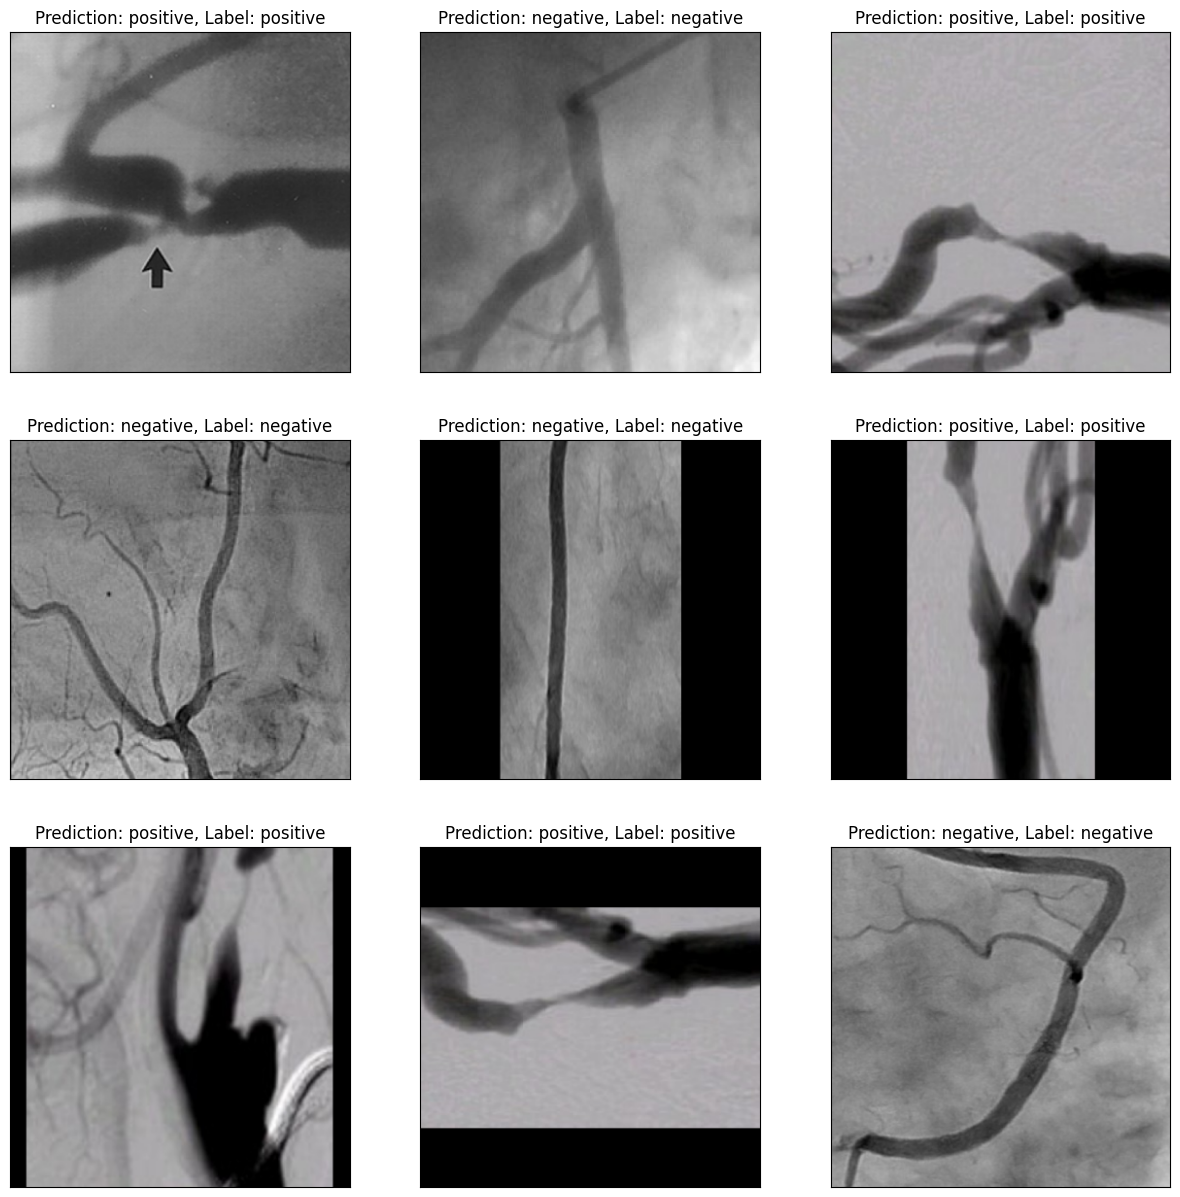

In [115]:
# Use the model to make prediction
for image_batch,label_batch in test_dataset.take(1):
    y_pred = np.argmax(model.predict(image_batch),axis=1)
    predicted_class = [class_names[x] for x in y_pred]
print(predicted_class)

plt.figure(figsize=(15,15))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(image_batch[i+9].numpy().astype('uint8'))
    plt.title(f"Prediction: {predicted_class[i+9]}, Label: {class_names[label_batch[i+9]]}")
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
plt.show()

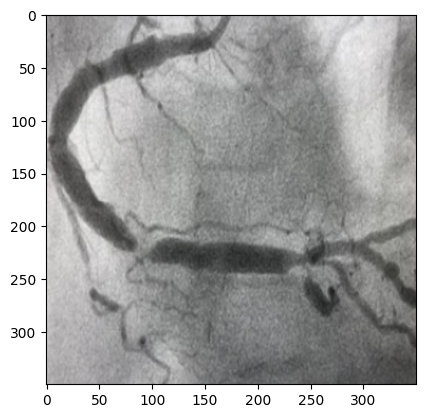

(350, 350, 3)
(1, 350, 350, 3)


In [121]:
# Load the image
img = cv2.imread(filename="artery.jpg")

# Check if the image was loaded successfully
if img is None:
    print("Error: Image not found or could not be loaded. Please check the file path.")
else:
    # Convert the image from BGR to RGB
    img = cv2.cvtColor(img, code=cv2.COLOR_BGR2RGB)

    # Resize the image
    img = cv2.resize(img, dsize=(350, 350))

    # Display the image
    plt.imshow(img)
    plt.axis('on')  # Hide axes
    plt.show()
print(img.shape)
img = np.expand_dims(img,axis=0)
print(img.shape)

In [120]:
prediction = model.predict(img)
class_names[np.argmax(prediction,axis=1)[0]]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 860ms/step


'positive'

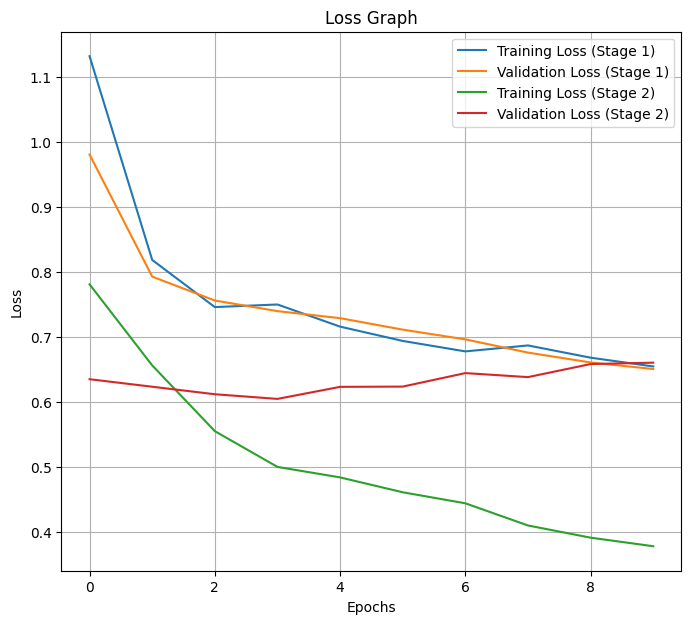

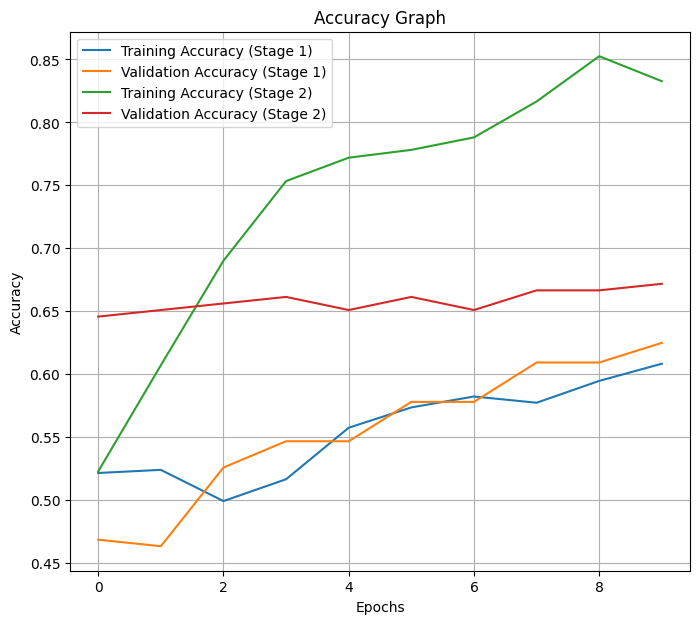

In [ ]:
import matplotlib.pyplot as plt

# Plotting the Loss graph
plt.figure(figsize=(8, 7))

# Plot loss for the first training phase
plt.plot(history_first.history['loss'], label='Training Loss (Stage 1)')
plt.plot(history_first.history['val_loss'], label='Validation Loss (Stage 1)')

# Plot loss for the second training phase
plt.plot(history_second.history['loss'], label='Training Loss (Stage 2)')
plt.plot(history_second.history['val_loss'], label='Validation Loss (Stage 2)')

plt.title('Loss Graph')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the Accuracy graph
plt.figure(figsize=(8, 7))

# Plot accuracy for the first training phase
plt.plot(history_first.history['accuracy'], label='Training Accuracy (Stage 1)')
plt.plot(history_first.history['val_accuracy'], label='Validation Accuracy (Stage 1)')

# Plot accuracy for the second training phase
plt.plot(history_second.history['accuracy'], label='Training Accuracy (Stage 2)')
plt.plot(history_second.history['val_accuracy'], label='Validation Accuracy (Stage 2)')

plt.title('Accuracy Graph')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
model.save('model/model.keras')